In [1]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv('diabetes.csv')

In [3]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
D = data[(data['Outcome'])!=0]
H = data[(data['Outcome'])==0]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( y = data['Outcome'].value_counts(), 
                    x = ['healthy','diabetic'],
                  )
    layout = dict(title = 'Count of Outcome variable')
    
    fig = dict(data = [trace],layout = layout)
    
    py.iplot(fig)


In [5]:
target_count()

In [6]:
def target_percentage():
    trace = go.Pie(labels = ['Healthy','Diabetes'],
                  values = data['Outcome'].value_counts()
                  )
    layout = dict(title= 'Distribution of Outcome variable')
    
    fig = dict(data=[trace],layout = layout)
    py.iplot(fig)

In [7]:
target_percentage()

In [8]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [9]:
def missing_plot(dataset,key) :
    null_feat = pd.DataFrame(len(dataset[key])-dataset.isnull().sum(),columns=['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2) #2 digit after .(decemal)
    
    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] , text = percentage_null['Count'],  textposition = 'auto')

    layout = dict(title =  "Missing Values (count & %)")
                   
    fig = dict(data = [trace],layout = layout)
    py.iplot(fig)
    

In [10]:
missing_plot(data, 'Outcome')

In [11]:
def correlation_plot():
    correlation = data.corr()
    matrics_cols = correlation.columns.tolist()
    corr_array = np.array(correlation)
    
    trace = go.Heatmap(z = corr_array,
                       x = matrics_cols,
                       y= matrics_cols,
                       colorscale='Viridis'
                      )
    
    layout = go.Layout(title = 'Correlation Matrix for variabels')
    
    fig = go.Figure(data=[trace],layout = layout)
    py.iplot(fig)

In [12]:
correlation_plot()

In [13]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [14]:
def plot_distribution(data_select,size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [15]:
plot_distribution('Insulin',0)

In [16]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [17]:
data.loc[(data['Outcome']==0)&(data['Insulin'].isnull()),'Insulin'] = 102.5
data.loc[(data['Outcome']==1)&(data['Insulin'].isnull()),'Insulin'] = 169.5

In [18]:
##### WE CAN USE JUST median_target INSTEAD plot_distribution

In [19]:
plot_distribution('Glucose',0)

In [20]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [21]:
data.loc[(data['Outcome']==0)&(data['Glucose'].isnull()),'Glucose'] = 107
data.loc[(data['Outcome']==1)&(data['Glucose'].isnull()),'Glucose'] = 140

In [22]:
plot_distribution('SkinThickness', 10)

In [23]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [24]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [25]:
plot_distribution('BloodPressure', 5)

In [26]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [27]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

In [28]:
plot_distribution('BMI', 0)

In [29]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [30]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

In [31]:
#plot distribution 
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

In [34]:
missing_plot(data, 'Outcome')

In [32]:
def plot_feat1_feat2(feat1,feat2):
    D = data[data['Outcome']!=0]
    H = data[data['Outcome']==0]
    
    trace0 = go.Scatter(  #Scatter for Diabetes patient
        x = D[feat1],
        y = D[feat2],
        name = 'diabetes',
        mode = 'markers',
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))
    
    trace1 = go.Scatter(   #Scatter for Healthy patient
        x = H[feat1],
        y = H[feat2],
        name = 'Healthy',
        mode = 'markers',
        marker =  dict(color = '#7EC0EE',line = dict(width = 1) )
    )
    
    layout = dict(title = feat1 +" "+"vs"+" "+ feat2)
    
    plots = [trace0,trace1]
    
    fig = dict(data=plots,layout = layout)
    
    py.iplot(fig)
    


In [33]:
plot_feat1_feat2('Glucose','Age')

In [37]:
target_col = ["Outcome"]
cat_cols   = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])

In [38]:
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [52]:
def correlation_plot():
    correlation = data.corr()    
    matrix_cols = correlation.columns.tolist()
    corr_array = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                      )

    
    layout = go.Layout(dict(title= 'correlation Matrix for variables',
                            margin = dict(r = 0,l =100,
                                         t = 0,b = 100,),
                           ))
    fig = go.Figure(data = [trace],layout= layout)
    py.iplot(fig)

In [53]:
correlation_plot()

In [41]:
matrics_cols

['Outcome',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [54]:
# Def X and Y
X = data.drop('Outcome', 1)
y = data['Outcome']

* **LightGBM : Hyperparameters ** :

    * learning_rate : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates
    * n_estimators : number of trees (or rounds)
    * num_leaves : number of leaves in full tree, default: 31
    * min_child_samples : minimal number of data in one leaf. Can be used to deal with over-fitting
    * min_child_weight : minimal sum hessian in one leaf.
    * subsample : randomly select part of data without resampling
    * max_depth : It describes the maximum depth of tree. This parameter is used to handle model overfitting.
    * colsample_bytree : LightGBM will randomly select part of features on each iteration if colsample_bytree smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
    * reg_alpha : regularization
    * reg_lambda : regularization
    
    * early_stopping_rounds : This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations

In [57]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  1.8min finished


In [58]:
def model_performance(model, subtitle) :   
    #Kfold
    cv = KFold(n_splits=5,shuffle=False, random_state = 42)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,test in cv.split(X,y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y.iloc[test], pred_proba[:,1])
        y_real.append(y.iloc[test])
        y_proba.append(pred_proba[:,1])
        fpr, tpr, t = roc_curve(y[test], pred_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc) 
    
    # Confusion matrix
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)
    
    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))

    #Roc curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name = "Roc : " ,
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #Precision - recall curve
    y_real = y
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    mean_auc=round(mean_auc,3)
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(mean_auc)+')',
                                          'Precision - Recall curve',
                                          ))
    #Trace and layout
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report (5 folds)</b><br>'+subtitle,
                        autosize = False, height = 830, width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

In [59]:
model_performance(lgbm_clf, 'LightGBM')

In [60]:
def scores_table(model, subtitle):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    res = []
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        res.append(scores)
    df = pd.DataFrame(res).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

    trace = go.Table(
        header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                    line = dict(color='#7D7F80'),
                    fill = dict(color='#a1c3d1'),
                    align = ['center'],
                    font = dict(size = 15)),
        cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                           np.round(df['accuracy'],3),
                           np.round(df['precision'],3),
                           np.round(df['recall'],3),
                           np.round(df['f1'],3),
                           np.round(df['roc_auc'],3)],
                   line = dict(color='#7D7F80'),
                   fill = dict(color='#EDFAFF'),
                   align = ['center'], font = dict(size = 15)))

    layout = dict(width=800, height=400, title = '<b>Cross Validation - 5 folds</b><br>'+subtitle, font = dict(size = 15))
    fig = dict(data=[trace], layout=layout)

    py.iplot(fig, filename = 'styled_table')

In [61]:
scores_table(lgbm_clf, 'LightGBM')

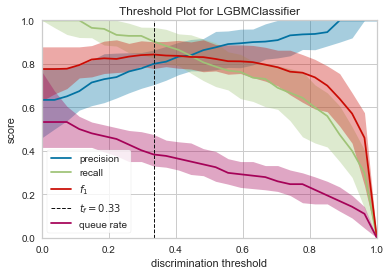

In [62]:
visualizer = DiscriminationThreshold(lgbm_clf)

visualizer.fit(X, y)  
visualizer.poof() 

In [63]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm_clf', lgbm_clf),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [1,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=5)

grid.fit(X,y)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.8697916666666666
Best Parameters: {'knn__n_neighbors': 26}


In [64]:
knn_clf = KNeighborsClassifier(n_neighbors = 25)

voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('lgbm', lgbm_clf)],
                     voting='soft', weights = [1,1])

In [65]:
model_performance(voting_clf, 'LightGBM & KNN')
scores_table(voting_clf, 'LightGBM & KNN')

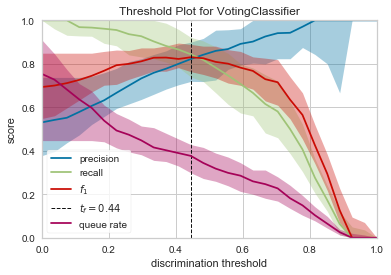

In [66]:
visualizer = DiscriminationThreshold(voting_clf)

visualizer.fit(X, y)  
visualizer.poof()  